# **01 - Entorno de Configuración**


**Requerimientos**:

- CUDA 10.1
- Python3 (preinstalado)
- Pytorch >= 1.5
- Detectron2
- OpenCV-Python (preinstalado)
- Pillow/scikit-image (preinstalado)

In [ ]:
# Pytorch
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
# Pyyaml
!pip install cython pyyaml==5.1
# COCO-Stuff API
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# Dominate
!pip install dominate==2.4.0
# Detectron2
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 27.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 5.4 MB/s 
  Created wheel fo

# **02 - Clonando repositorio**

In [ ]:
!git clone https://github.com/ericsujw/InstColorization
%cd InstColorization/

Cloning into 'InstColorization'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 211 (delta 15), reused 11 (delta 11), pack-reused 177
Receiving objects: 100% (211/211), 6.11 MiB | 22.18 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/InstColorization


# **03 - Descargando el modelo pre-entrenado**

In [ ]:
!sh scripts/download_model.sh

Downloading...
Finish download.
Archive:  checkpoints.zip
   creating: checkpoints/coco_finetuned_mask_256_ffs/
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_GComp.pth  
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_G.pth  
  inflating: checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth  
   creating: checkpoints/coco_finetuned_mask_256/
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_GComp.pth  
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_G.pth  
  inflating: checkpoints/coco_finetuned_mask_256/latest_net_GF.pth  
   creating: checkpoints/siggraph_retrained/
  inflating: checkpoints/siggraph_retrained/latest_net_G.pth  


# **04 - Detectando los bounding box de objetos**


**Configuración del Detectron2**

In [ ]:
from os.path import join, isfile, isdir
from os import listdir
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from argparse import ArgumentParser

import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

import torch

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

model_final_2d9806.pkl: 431MB [00:13, 31.8MB/s]                           


Creemos una carpeta de bounding box para guardar los resultados de nuestra predicción.

In [ ]:
input_dir = "example"
image_list = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
output_npz_dir = "{0}_bbox".format(input_dir)
if os.path.isdir(output_npz_dir) is False:
    print('Create path: {0}'.format(output_npz_dir))
    os.makedirs(output_npz_dir)

Create path: example_bbox


Aquí simplemente tomamos el canal L como nuestra entrada y nos aseguramos de que podamos obtener resultados de predicción de los bounding box consistentes aunque la imagen original sea imágenes en color.

** La variable L es una correlación de la luminosidad

L - codifica la información de brillo.

a - componente de color que va del verde al magenta.

b - componente de color que va del azul al amarillo.

In [ ]:
for image_path in image_list:
    img = cv2.imread(join(input_dir, image_path))
    lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab_image)
    l_stack = np.stack([l_channel, l_channel, l_channel], axis=2)
    outputs = predictor(l_stack)
    save_path = join(output_npz_dir, image_path.split('.')[0])
    pred_bbox = outputs["instances"].pred_boxes.to(torch.device('cpu')).tensor.numpy()
    pred_scores = outputs["instances"].scores.cpu().data.numpy()
    np.savez(save_path, bbox = pred_bbox, scores = pred_scores)

Ahora tenemos los resultados de la predicción de todas las imágenes.

In [ ]:
!ls example_bbox

000000022969.npz  574100c6e31a1dcd096476eb2d632b3c.npz
000000023781.npz  8b01a894fb91025a1dc77611838e9d13.npz
000000046872.npz  925f179ba736e15e89bfd6d88e0bba56.npz
000000050145.npz  e9b6826aa623549ec77bbc0275002779.npz


# **05 - Colorizando imágenes**

Configuramos librerias

In [ ]:
import sys
import time
from options.train_options import TestOptions
from models import create_model

import torch
from tqdm import tqdm_notebook

from fusion_dataset import Fusion_Testing_Dataset
from util import util
import multiprocessing
multiprocessing.set_start_method('spawn', True)

torch.backends.cudnn.benchmark = True

sys.argv = [sys.argv[0]]
opt = TestOptions().parse()

**Creamos una carpeta de resultados** para guardar nuestras imágenes de color predichas y leer el cargador de conjuntos de datos. 

In [ ]:
save_img_path = opt.results_img_dir
if os.path.isdir(save_img_path) is False:
    print('Create path: {0}'.format(save_img_path))
    os.makedirs(save_img_path)
opt.batch_size = 1
dataset = Fusion_Testing_Dataset(opt, -1)
# Dataset Loader
dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size)

dataset_size = len(dataset)
print('#Testing images = %d' % dataset_size)

Create path: results
#Testing images = 8


Cargamos el modelo previamente entrenado

In [ ]:
model = create_model(opt)
model.setup_to_test('coco_finetuned_mask_256_ffs')

initialize network with normal
initialize network with normal
initialize network with normal
model [FusionModel] was created
load Fusion model from checkpoints/coco_finetuned_mask_256_ffs/latest_net_GF.pth


Empezamos a colorear todas las imágenes en el `dataset loader`

In [ ]:
count_empty = 0
for data_raw in tqdm_notebook(dataset_loader):
    data_raw['full_img'][0] = data_raw['full_img'][0].cuda()
    if data_raw['empty_box'][0] == 0:
        data_raw['cropped_img'][0] = data_raw['cropped_img'][0].cuda()
        box_info = data_raw['box_info'][0]
        box_info_2x = data_raw['box_info_2x'][0]
        box_info_4x = data_raw['box_info_4x'][0]
        box_info_8x = data_raw['box_info_8x'][0]
        cropped_data = util.get_colorization_data(data_raw['cropped_img'], opt, ab_thresh=0, p=opt.sample_p)
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_input(cropped_data)
        model.set_fusion_input(full_img_data, [box_info, box_info_2x, box_info_4x, box_info_8x])
        model.forward()
    else:
        count_empty += 1
        full_img_data = util.get_colorization_data(data_raw['full_img'], opt, ab_thresh=0, p=opt.sample_p)
        model.set_forward_without_box(full_img_data)
    model.save_current_imgs(join(save_img_path, data_raw['file_id'][0] + '.png'))
print('{0} images without bounding boxes'.format(count_empty))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/8 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0 images without bounding boxes


# **06 - Visualizando resultados**

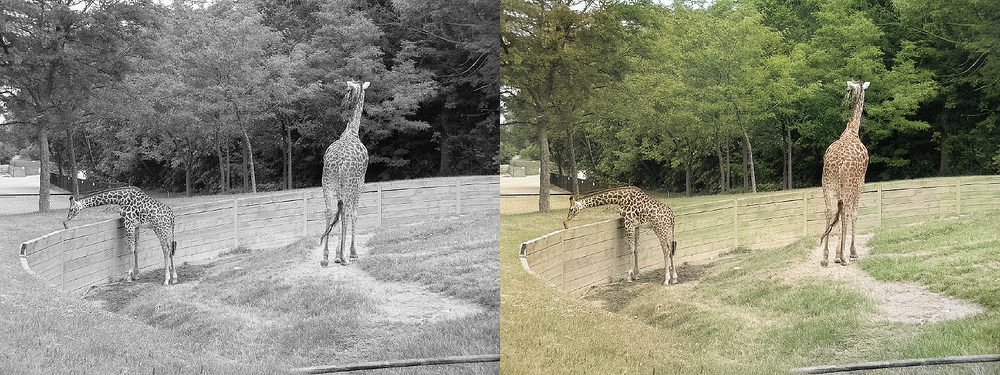

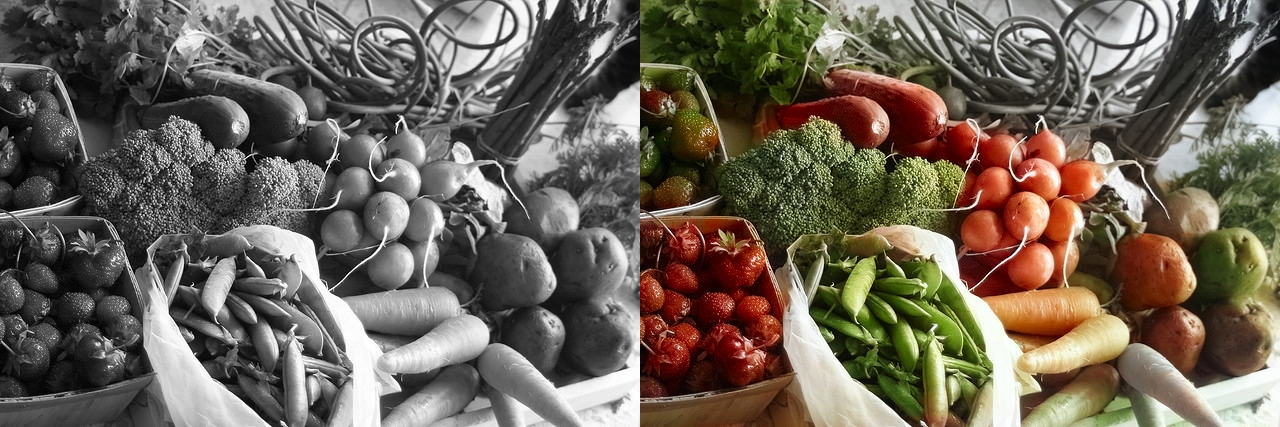

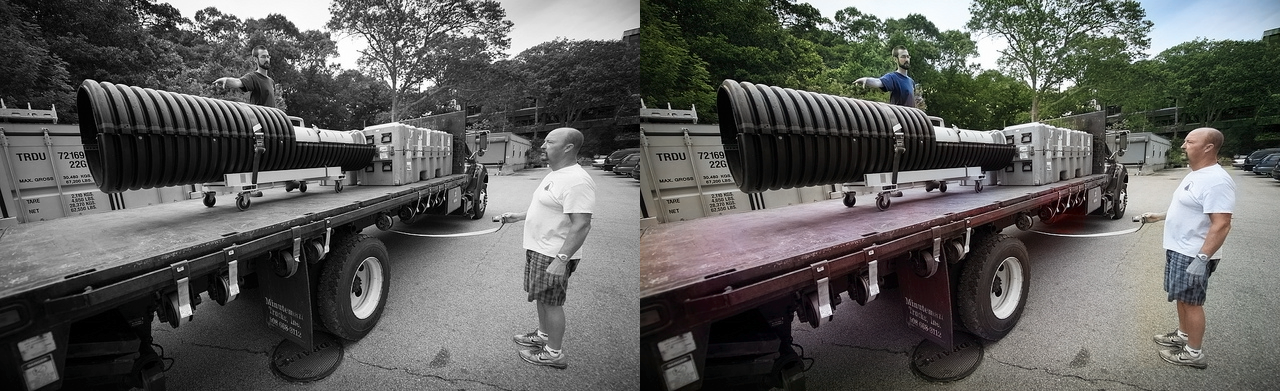

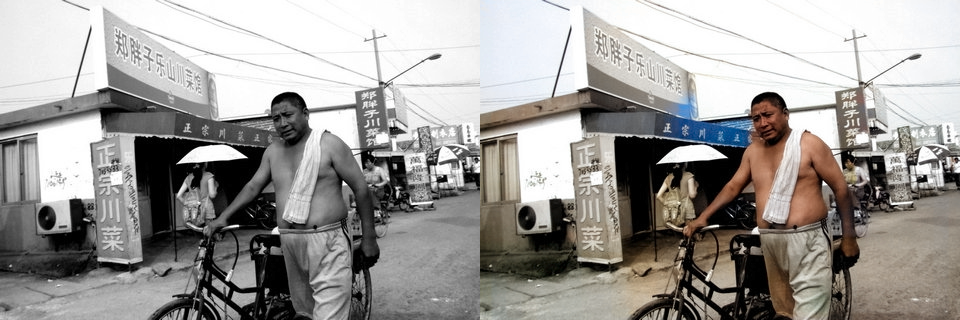

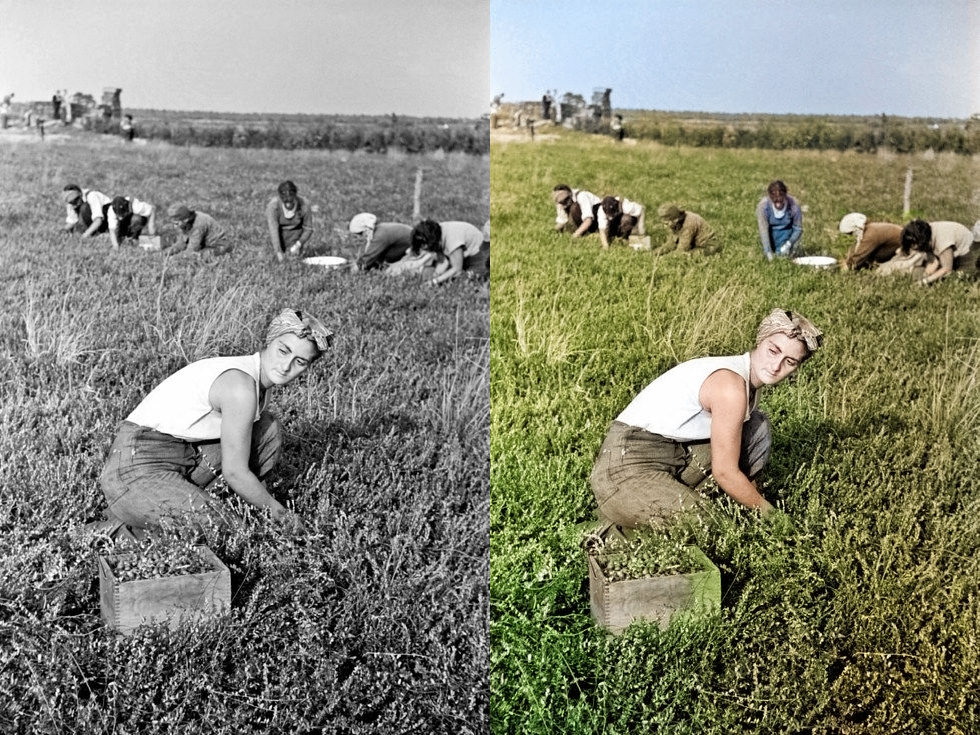

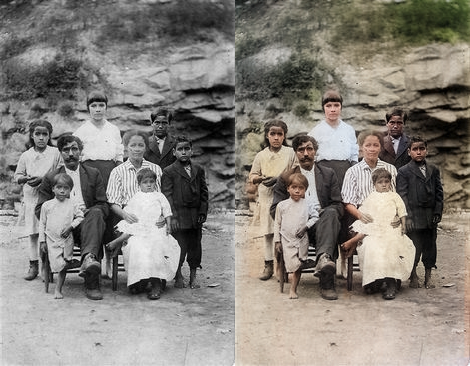

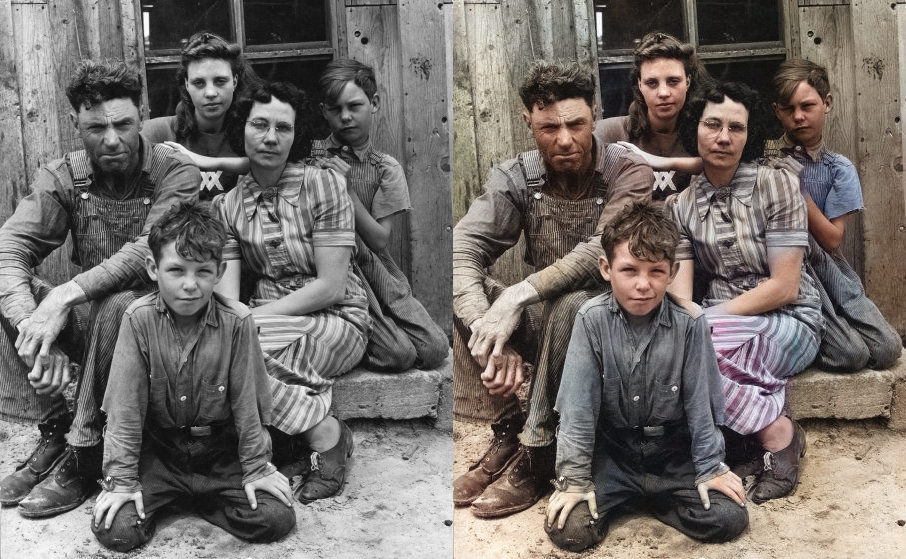

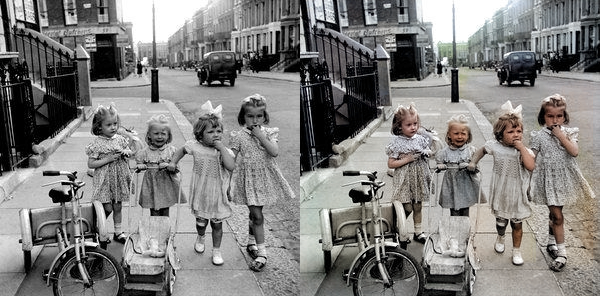

In [ ]:
from google.colab.patches import cv2_imshow

# Listado de los nombres de las imágenes
img_name_list = ['000000022969', '000000023781', '000000046872', '000000050145',
                 '574100c6e31a1dcd096476eb2d632b3c', '8b01a894fb91025a1dc77611838e9d13',
                 '925f179ba736e15e89bfd6d88e0bba56', 'e9b6826aa623549ec77bbc0275002779']

for i in range(len(img_name_list)):
  # Valores de index entre 0 y 7 conforme al tamaño de la lista
  SHOW_INDEX = i

  # Leemos la imagen
  img = cv2.imread('example/'+img_name_list[SHOW_INDEX]+'.jpg')

  lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  l_channel, _, _ = cv2.split(lab_image)

  img = cv2.imread('results/'+img_name_list[SHOW_INDEX]+'.png')
  lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
  _, a_pred, b_pred = cv2.split(lab_image)
  a_pred = cv2.resize(a_pred, (l_channel.shape[1], l_channel.shape[0]))
  b_pred = cv2.resize(b_pred, (l_channel.shape[1], l_channel.shape[0]))
  gray_color = np.ones_like(a_pred) * 128

  gray_image = cv2.cvtColor(np.stack([l_channel, gray_color, gray_color], 2), cv2.COLOR_LAB2BGR)
  color_image = cv2.cvtColor(np.stack([l_channel, a_pred, b_pred], 2), cv2.COLOR_LAB2BGR)

  cv2_imshow(np.concatenate([gray_image, color_image], 1))